In [11]:
%matplotlib inline
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from decimal import Decimal
import matplotlib.gridspec as gridspec

In [12]:
def human_format(x):
    sigpart = 0
    suffix = ""
    if x < .01:
        return "{:.0e}".format(x)
    if x < 1:
        return "{:.2f}".format(x)
    if x < 1000:
        return "{:.3g}".format(x)
    elif x < 1000000:
        sigpart = x / 1000
        suffix = "k"
    elif x < 1000000000:
        sigpart = x / 1000000
        suffix = "M"
    else:
        sigpart = x / 1000000000
        suffix = "B"
    return "{:.3g}{}".format(sigpart, suffix)

In [13]:
def plot_data_1(filter_data, lesion_data, throughput_data, title):
    f, axs = plt.subplots(1,3, figsize=(6,2.5), dpi=100)

    ### Lesion ###
    ax1 = plt.subplot(131)
    index = ['Baseline','+Simple','+Markov','+RTT']
    data = {'amount': lesion_data}
    trans = pd.DataFrame(data=data,index=index)

    my_plot = trans.plot(ax=ax1, kind='bar', legend=None)
    ax1.set_yscale('log')
    ax1.set_ylabel('Throughput (QPS)')
    ax1.set_xticklabels(labels=index, rotation='-45')
    ax1.yaxis.grid(True)
    ax1.set_title('a', fontsize=10)
    
    pos_offset = 1.2
    loop = 0
    for i, row in trans.iterrows():
        y = row['amount'] * pos_offset
        my_plot.annotate(human_format(np.absolute(row['amount'])),(loop,y),ha="center", fontsize=8)
        loop += 1
    my_plot.set_ylim(ymax=2e5)
    
    ### Throughput ###
    ax2 = plt.subplot(132, sharey=ax1)
    index = ['Simple','Markov','RTT','MaxEnt']
    data = {'amount': throughput_data[1:]}
    trans = pd.DataFrame(data=data,index=index)

    my_plot = trans.plot(ax=ax2, kind='bar', legend=None)
    ax2.set_yscale('log')
    ax2.set_xticklabels(labels=index, rotation='-45')
    ax2.yaxis.grid(True)
    ax2.set_title('b', fontsize=10)
    
    pos_offset = 1.2
    loop = 0
    for i, row in trans.iterrows():
        y = row['amount'] * pos_offset
        my_plot.annotate(human_format(np.absolute(row['amount'])),(loop,y),ha="center", fontsize=8)
        loop += 1
    my_plot.set_ylim(ymax=1e8)
    
    ### Filter ###
    ax0 = plt.subplot(133)
    index = ['Simple','Markov','RTT','MaxEnt']
    filter_data = [d / filter_data[0] for d in filter_data]
    data = {'amount': filter_data}
    trans = pd.DataFrame(data=data,index=index)

    #Plot and label
    my_plot = trans.plot(ax=ax0, kind='bar', stacked=True, legend=None)
    ax0.set_ylabel('Fraction hit')
    ax0.set_xticklabels(labels=index, rotation='-45')
    ax0.yaxis.grid(True)
    pos = ax0.get_position()
    ax0.set_position([pos.x0 + 0.075, pos.y0, pos.width, pos.height] )
    ax0.set_title('c', fontsize=10)
    
    pos_offset = 0.05
    loop = 0
    for i, row in trans.iterrows():
        y = row['amount'] + pos_offset
        my_plot.annotate("{:,.3f}".format(np.absolute(row['amount'])),(loop,y),ha="center", fontsize=8)
        loop += 1
    my_plot.set_ylim(ymax=1.2)

    f.set_size_inches(6, 1.6)
    plt.savefig("cascade_milan_combined.pdf", bbox_inches='tight')
    plt.show()

In [14]:
def plot_data_2(apl_times, merge_times, query_times, title):
    f, axs = plt.subplots(1,1, figsize=(6,2.3), dpi=100)
    ax = axs
    x = range(6)
    index = ['?', 'Baseline', '+Simple', '+Markov', '+RTT', 'Merge12a', 'Merge12b']
    
    p1 = plt.bar(x, merge_times, width=0.6, color='C0')
    p2 = plt.bar(x, query_times, width=0.6, bottom=merge_times, color='C1')
    ax.set_ylabel('Runtime (s)')
    ax.set_xticklabels(labels=index, rotation='-45')
    ax.yaxis.grid(True)
    ax.set_xticks(x, index)
    ax.legend((p2[0], p1[0]), ('Estimation', 'Merge'), frameon=False)

    pos_offset = 1.5
    loop = 0
    for i in range(len(merge_times)):
        y = merge_times[i] + query_times[i] + pos_offset
        ax.annotate(human_format(merge_times[i] + query_times[i]),(loop,y),ha="center")
        loop += 1
    
    plt.ylim(ymax=50)
    f.tight_layout()
    plt.savefig("cascade_milan_mb.pdf", bbox_inches='tight')
    plt.show()

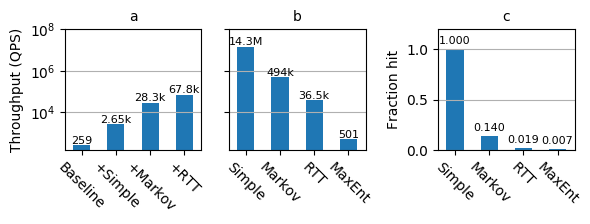

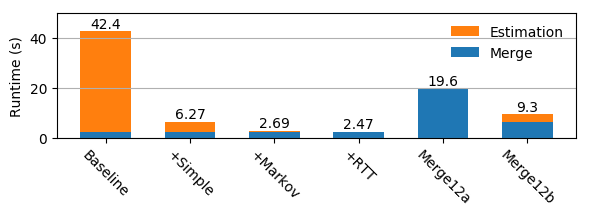

In [15]:
results = pd.read_csv("../javamsketch/results/cascade_milan.csv")

cRow = results[(results['simple'] == True) & (results['markov'] == True) & (results['racz'] == True)]
filter_data = cRow[['simple_hit', 'markov_hit', 'racz_hit', 'maxent_hit']].squeeze().tolist()
lesion_data = results.loc[:,'overall_throughput'].dropna().tolist()
throughput_data = cRow[['overall_throughput', 'simple_throughput', 'markov_throughput', 'racz_throughput', 'maxent_throughput']].squeeze().tolist()
throughput_data = [float(t) for t in throughput_data]
time_data = cRow[['simple_time', 'markov_time', 'racz_time', 'maxent_time']].squeeze().tolist()

plot_data_1(filter_data, lesion_data, throughput_data, "Cascades on MacroBase: milan")

apl_times = results.loc[:,'avg_apltime'].dropna().tolist()
merge_times = results.loc[:,'avg_mergetime'].dropna().tolist()
query_times = results.loc[:,'avg_querytime'].dropna().tolist()

plot_data_2(apl_times, merge_times, query_times, "MacroBase runtime: milan")

# Results

In [10]:
pd.read_csv("../javamsketch/results/cascade_milan_1519818230.csv").to_csv(
    "../javamsketch/results/cascade_milan.csv")